In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Paths to data and labels
TRAIN_DATA_PATH = r'D:\UniGe\2\CV\Babel Project\Normalized Data\train_ntu_sk_60_pre.npy'
VAL_DATA_PATH   = r'D:\UniGe\2\CV\Babel Project\Normalized Data\val_ntu_sk_60_pre.npy'
# Use validation for final evaluation since test labels are unavailable

TRAIN_LABEL_PATH = r'D:\UniGe\2\CV\Babel Project\BABEL\action_recognition\data\release\train_label_60.pkl'
VAL_LABEL_PATH   = r'D:\UniGe\2\CV\Babel Project\BABEL\action_recognition\data\release\val_label_60.pkl'

# Hyperparameters
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 1e-4
EPOCHS        = 50
EARLY_STOP    = 10
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Dataset class
class PoseDataset(Dataset):
    def __init__(self, data_path, label_path):
        self.data = np.load(data_path)
        with open(label_path, 'rb') as f:
            labels = pickle.load(f)[1][0]
        self.labels = np.array(labels, dtype=int)
        assert len(self.data) == len(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = np.squeeze(self.data[idx], axis=-1)  # (3,T,25)
        y = self.labels[idx]
        return torch.from_numpy(x).float(), y

# Model definition
class PoseLSTM(nn.Module):
    def __init__(self, in_dim=75, hidden_dim=128, num_layers=2, num_classes=60, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout_fc = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        N, C, T, V = x.size()
        x = x.permute(0, 2, 3, 1).reshape(N, T, C * V)  # (N,T,75)
        _, (h_n, _) = self.lstm(x)
        h = torch.cat([h_n[-2], h_n[-1]], dim=1)        # (N, hidden*2)
        h = self.dropout_fc(h)
        return self.fc(h)


In [5]:
# Load datasets
train_ds = PoseDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH)
val_ds   = PoseDataset(VAL_DATA_PATH,   VAL_LABEL_PATH)

# Create WeightedRandomSampler for class-balanced sampling
class_counts = np.bincount(train_ds.labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_ds.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
dl_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
dl_val   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,     num_workers=0)

# Initialize model, loss, optimizer, scheduler
model = PoseLSTM().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training with early stopping
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
best_val_loss = float('inf')
patience_counter = 0

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    tloss, tacc, tsamples = 0, 0, 0
    for x, y in tqdm(dl_train, desc=f"Epoch {epoch}/{EPOCHS} [Train]"):
        x, y = x.to(DEVICE), y.to(DEVICE).long()
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        preds = out.argmax(dim=1)
        tloss += loss.item() * x.size(0)
        tacc  += (preds==y).sum().item()
        tsamples += x.size(0)
    train_loss = tloss/tsamples
    train_acc  = tacc/tsamples

    # Validate
    model.eval()
    vloss, vacc, vsamples = 0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(dl_val, desc=f"Epoch {epoch}/{EPOCHS} [Val]"):
            x, y = x.to(DEVICE), y.to(DEVICE).long()
            out = model(x)
            loss = criterion(out, y)
            preds = out.argmax(dim=1)
            vloss += loss.item() * x.size(0)
            vacc  += (preds==y).sum().item()
            vsamples += x.size(0)
    val_loss = vloss/vsamples
    val_acc  = vacc/vsamples

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'checkpoints/best_pose_lstm.pth')
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP:
            print(f"Early stopping at epoch {epoch}")
            break

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}: train loss {train_loss:.4f}, acc {train_acc:.4f} | val loss {val_loss:.4f}, acc {val_acc:.4f}")

Epoch 1/50 [Val]: 100%|██████████| 267/267 [00:02<00:00, 132.96it/s]


Epoch 1: train loss 3.6726, acc 0.0947 | val loss 3.5182, acc 0.1420


Epoch 2/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.42it/s]


Epoch 2: train loss 3.3321, acc 0.1592 | val loss 3.4928, acc 0.1150


Epoch 3/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.63it/s]


Epoch 3: train loss 3.1608, acc 0.1964 | val loss 3.2182, acc 0.2296


Epoch 4/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 142.28it/s]


Epoch 4: train loss 3.0154, acc 0.2292 | val loss 3.0265, acc 0.2744


Epoch 5/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.68it/s]


Epoch 5: train loss 2.8849, acc 0.2573 | val loss 2.9600, acc 0.2762


Epoch 6/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.12it/s]


Epoch 6: train loss 2.7499, acc 0.2858 | val loss 2.9560, acc 0.2744


Epoch 7/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 137.66it/s]


Epoch 7: train loss 2.7263, acc 0.2909 | val loss 2.9959, acc 0.2678


Epoch 8/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 139.49it/s]


Epoch 8: train loss 2.6578, acc 0.3050 | val loss 2.9600, acc 0.2739


Epoch 9/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 137.60it/s]


Epoch 9: train loss 2.5332, acc 0.3295 | val loss 2.8416, acc 0.2975


Epoch 10/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 139.43it/s]


Epoch 10: train loss 2.4620, acc 0.3433 | val loss 2.8480, acc 0.2979


Epoch 11/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.16it/s]


Epoch 11: train loss 2.5151, acc 0.3344 | val loss 2.8534, acc 0.2924


Epoch 12/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 138.47it/s]


Epoch 12: train loss 2.3907, acc 0.3576 | val loss 2.8325, acc 0.2977


Epoch 13/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 139.76it/s]


Epoch 13: train loss 2.3567, acc 0.3641 | val loss 2.7969, acc 0.3051


Epoch 14/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 134.61it/s]


Epoch 14: train loss 2.3098, acc 0.3766 | val loss 2.8377, acc 0.2879


Epoch 15/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 139.94it/s]


Epoch 15: train loss 2.2437, acc 0.3886 | val loss 2.7775, acc 0.3086


Epoch 16/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 138.16it/s]


Epoch 16: train loss 2.2162, acc 0.3954 | val loss 2.8074, acc 0.2944


Epoch 17/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.42it/s]


Epoch 17: train loss 2.2034, acc 0.3939 | val loss 2.7799, acc 0.3033


Epoch 18/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 139.29it/s]


Epoch 18: train loss 2.1249, acc 0.4088 | val loss 2.8010, acc 0.3104


Epoch 19/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 141.55it/s]


Epoch 19: train loss 2.1627, acc 0.4057 | val loss 2.8000, acc 0.2975


Epoch 20/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 141.15it/s]


Epoch 20: train loss 2.2895, acc 0.3793 | val loss 2.7778, acc 0.3052


Epoch 21/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 142.26it/s]


Epoch 21: train loss 2.0744, acc 0.4208 | val loss 2.7932, acc 0.3032


Epoch 22/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 135.61it/s]


Epoch 22: train loss 1.9622, acc 0.4476 | val loss 2.7654, acc 0.3090


Epoch 23/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.29it/s]


Epoch 23: train loss 1.9090, acc 0.4574 | val loss 2.7626, acc 0.3022


Epoch 24/50 [Val]: 100%|██████████| 267/267 [00:02<00:00, 130.20it/s]


Epoch 24: train loss 1.8685, acc 0.4665 | val loss 2.7782, acc 0.3060


Epoch 25/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 134.62it/s]


Epoch 25: train loss 1.8647, acc 0.4660 | val loss 2.7576, acc 0.3118


Epoch 26/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 139.20it/s]


Epoch 26: train loss 1.8445, acc 0.4687 | val loss 2.7687, acc 0.3099


Epoch 27/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 137.87it/s]


Epoch 27: train loss 1.8228, acc 0.4731 | val loss 2.7652, acc 0.3136


Epoch 28/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 138.92it/s]


Epoch 28: train loss 1.8069, acc 0.4790 | val loss 2.7574, acc 0.3136


Epoch 29/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 138.60it/s]


Epoch 29: train loss 1.7854, acc 0.4829 | val loss 2.8064, acc 0.3010


Epoch 30/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.06it/s]


Epoch 30: train loss 1.7680, acc 0.4873 | val loss 2.7617, acc 0.3124


Epoch 31/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 139.58it/s]


Epoch 31: train loss 1.7401, acc 0.4919 | val loss 2.7513, acc 0.3169


Epoch 32/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 142.35it/s]


Epoch 32: train loss 1.7568, acc 0.4906 | val loss 2.7668, acc 0.3116


Epoch 33/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 146.34it/s]


Epoch 33: train loss 1.7342, acc 0.4955 | val loss 2.7758, acc 0.3044


Epoch 34/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 143.48it/s]


Epoch 34: train loss 1.6980, acc 0.5016 | val loss 2.7255, acc 0.3230


Epoch 35/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 141.57it/s]


Epoch 35: train loss 1.7131, acc 0.4982 | val loss 2.7833, acc 0.3010


Epoch 36/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 143.81it/s]


Epoch 36: train loss 1.6935, acc 0.5056 | val loss 2.7956, acc 0.3023


Epoch 37/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 134.28it/s]


Epoch 37: train loss 1.6840, acc 0.5044 | val loss 2.7851, acc 0.3049


Epoch 38/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.38it/s]


Epoch 38: train loss 1.6468, acc 0.5138 | val loss 2.8035, acc 0.3070


Epoch 39/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 139.42it/s]


Epoch 39: train loss 1.6527, acc 0.5109 | val loss 2.8209, acc 0.3144


Epoch 40/50 [Val]: 100%|██████████| 267/267 [00:02<00:00, 127.40it/s]


Epoch 40: train loss 1.6488, acc 0.5123 | val loss 2.8179, acc 0.3078


Epoch 41/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.39it/s]


Epoch 41: train loss 1.5575, acc 0.5326 | val loss 2.8080, acc 0.3074


Epoch 42/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 138.76it/s]


Epoch 42: train loss 1.5410, acc 0.5366 | val loss 2.7864, acc 0.3163


Epoch 43/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.41it/s]


Epoch 43: train loss 1.5124, acc 0.5420 | val loss 2.7944, acc 0.3136


Epoch 44/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 140.59it/s]

Early stopping at epoch 44


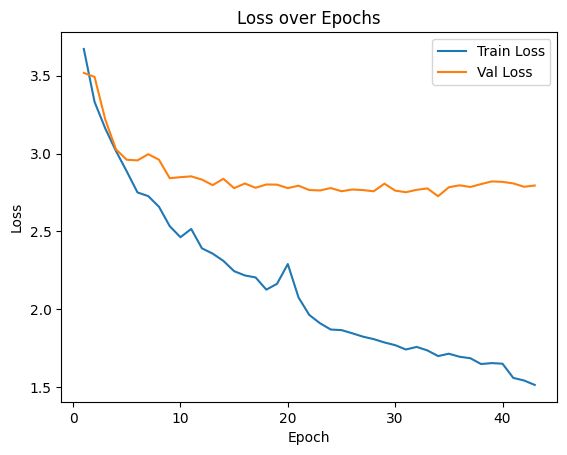

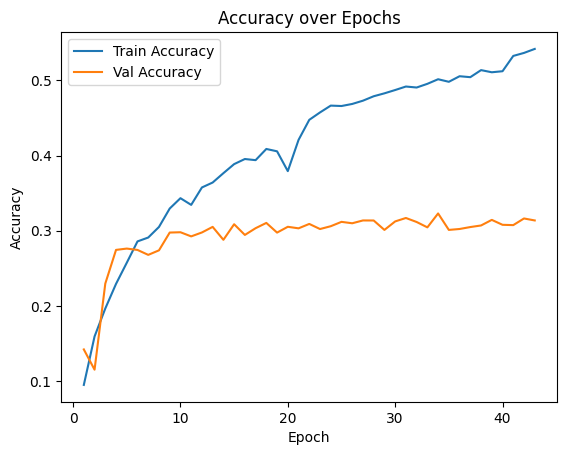

In [7]:
# Plot training history
epochs = range(1, len(history['train_loss'])+1)
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over Epochs'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'],   label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over Epochs'); plt.legend(); plt.show()
